#### Me Trying to Apply RNN to Name Classification (自己一定要练习一下)

(单独开一个 notebook 好对比)

In [1]:
import sys
import os

# This is a nice trick to add other python file to this notebook, 这样就挺方便的!!!
# 本质上就是告诉 python interpreter, 你也去看一下我给你添加的这个 file path， 然后正好是我要 import 的那个 path
# 但是这个方法好像有点小问题，就是你 import 的文件改了，你这个kernel 也得 refresh
# "sys.path contains a list of directories that the interpreter will search in for the required module"
#  credit: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook  

# 这里好像非得 join ".." 才行
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/PyTorch_RNN/pytorch-examples/rnn-name-classification")



In [2]:
from utils import *
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

In [3]:
category_name_map, all_categories = load_data('./pytorch-examples/rnn-name-classification/data/names/*.txt')
n_categories = len(all_categories)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(n_categories)

18


In [4]:
class MY_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MY_RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # batch_first=True then we need to use shape of (batch_n, seq_len, input_feature_len) for input 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) # if you are using GRU
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # if using LSTM
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
        #self.softmax = nn.LogSoftmax(dim=1) # add this line if you use NLLLoss()
        
    def forward(self, x):

        # num_layers x N x hidden_size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # if using LSTM
        
        out, h_n = self.rnn(x, h0)
        # out, h_n = self.gru(x, h0) # if you are using GRU
        #out, (h_n, c_n) = self.lstm(x, (h0,c0))  # if you are using LSTM
        
        # h_n: 即 给你 每个 batch 的最后一个 t 的 hidden state (比如两层 RNN 就两个 hidden state 都给你） ，
        #    所以 dim 是 (num_layers, batch_size, output_size), 那么我们就要 h_n[-1, :, :] 来拿到final output
        out = h_n[-1, :, :]

        out = self.fc(out)
        
        #out = self.softmax(out) # add this line if you use NLLLoss()
        
        #crossEntropy 期待 n x class_size  的 un-normalized proability array
        # 所以 this outputs a 1 x 18 of un-normalized proability array
        #这种实际练习的时候，估计得给一个 example input tensor 然后 foward path 过一遍print 一下才知道
        return out

In [5]:
input_size = N_LETTERS
hidden_size = 128
num_classes = n_categories
learning_rate = 0.005
num_layers = 1

# 应该是可以直接用这个 model 但是 training 的时候注意一下， 因为 seq_len 是 letter len
model = MY_RNN(input_size=input_size, 
               hidden_size=hidden_size, 
               num_layers=num_layers, 
               num_classes=num_classes).to(device)



In [6]:
# Loss and optimizer
# loss_func = nn.NLLLoss() # 如果不用 CrossEntropy 而用 NLLLoss + softmax

loss_func = nn.CrossEntropyLoss() # this is basically SoftMax + NLLLoss

#这个不好用，得查一下为啥? 哦，因为 adam 是自己调节 learning rate 的，我不传 learning rate 就 没问题了
optimizer = torch.optim.Adam(model.parameters())  
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# helper function to turn tensor output into a category name
def category_from_output(output):
    #通过 argmax 拿到 softmax output 的最大一个值的 index 然后就可以 look up for item name
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [8]:

def train_helper(name_tensor, category_tensor):

    # reshape becaues we have batch_first = true, 所以我得 (batch_n, seq_n, feature_n) 这个 shape
    # 这里 -1 是 default compute 的 word_len 也就是 seq_len
    name_tensor = name_tensor.reshape(1, -1, 57)
    
    output = model(name_tensor)
    # 好像非得把 size 18 转成 1x18 因为CrossEntropyLoss 是期待 n 个 sample (这里只有一个)
    # 然后 probably array of size 18
    # output = output.reshape(1, output.size(0))
#     print(f"output {output}")
 
    #category_tensor = torch.tensor([category_tensor.item()], dtype=torch.long)     
        
#     print(f"category_tensor {category_tensor}")
  
    # input shape to loss_func 参考这里: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    # 对于 target with class indices 的写法，
    #   - output 需要是 batch_n x num_class (probability in float) 的 shape
    #   - target 需要是 batch_n 这个 1d array 的 shape, 然后每个值是对应的 class index
    
    loss = loss_func(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

Iter Iter_Percent Loss Name/Guess Correct
5000 5.0 1.6336 Cabral / Spanish WRONG (Portuguese)
10000 10.0 3.2730 Jobst / French WRONG (Czech)
15000 15.0 0.3789 Brambani / Italian CORRECT
20000 20.0 1.7738 Durand / French WRONG (English)
25000 25.0 0.1450 Noh / Korean CORRECT
30000 30.0 5.3150 Chastain / Arabic WRONG (French)
35000 35.0 0.0104 Oh  / Korean CORRECT
40000 40.0 0.0468 Rudawski / Polish CORRECT
45000 45.0 0.1805 Law / Chinese CORRECT
50000 50.0 0.0171 Taflambas / Greek CORRECT
55000 55.00000000000001 0.8106 Cihak / Czech CORRECT
60000 60.0 1.3697 Elsmore / German WRONG (English)
65000 65.0 0.0571 Stramba / Czech CORRECT
70000 70.0 0.1679 Filipek / Polish CORRECT
75000 75.0 0.0565 Wilson / Scottish CORRECT
80000 80.0 1.7792 Puga / Arabic WRONG (Spanish)
85000 85.0 1.0505 Rothwell / English CORRECT
90000 90.0 0.0489 Sokal / Polish CORRECT
95000 95.0 0.0660 O'Hare / Irish CORRECT
100000 100.0 0.1095 Ha / Vietnamese CORRECT


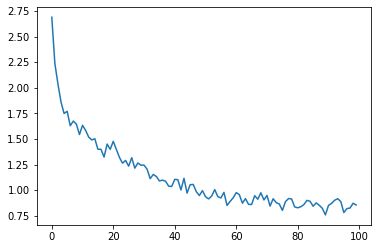

In [9]:
current_loss = 0
all_losses_list = [] #为了后面画图用
plot_steps, print_steps = 1000, 5000
n_iters = 100000 #10000 个 epoch?

print("Iter Iter_Percent Loss Name/Guess Correct")
for i in range(n_iters):
    # category_lines is a category to name list map
    category, name, category_tensor, name_tensor = random_training_example(category_name_map, all_categories)
    
#     print(f"name: {name}")
    
    output, loss = train_helper(name_tensor, category_tensor)
    current_loss += loss # 累加 loss 为了 plot ，你看下面我 plot step 一用完，就 reset 了
    
    if (i+1) % plot_steps == 0:
        all_losses_list.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        # output[0] 因为我们 output 是 1 x num_class 但是我们需要拿到 
        guess = category_from_output(output[0])
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {name} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses_list)
plt.show()

In [10]:
# Model Evaluation
model.eval()
total = 1000
n_correct = 0

for i in range(total):
    with torch.no_grad():
        category, name, category_tensor, name_tensor = random_training_example(category_name_map, 
                                                                               all_categories)
        
        name_tensor = name_tensor.reshape(1, -1, 57) # 别忘记加这行了... 
        guess = model(name_tensor)
        guess = category_from_output(guess[0])
        print(f'name {name} guess {guess}, category {category}')
        if(category == guess):
            n_correct+=1
            

print(f'Accuracy {100 * n_correct / total}')
        
        


name Arlotti guess Italian, category Italian
name Matos guess Portuguese, category Portuguese
name Date guess Dutch, category Japanese
name O'Hannagain guess Irish, category Irish
name Ikeda guess Japanese, category Japanese
name Salisbury guess Arabic, category English
name Hautum guess Dutch, category Dutch
name Kourempes guess Dutch, category Greek
name Spano guess Dutch, category Italian
name Kaczka guess Polish, category Polish
name Fujioka guess Japanese, category Japanese
name Letsos guess Portuguese, category Greek
name Van guess Vietnamese, category Vietnamese
name Bata guess Japanese, category Arabic
name Abreu guess Portuguese, category Spanish
name Beek guess Dutch, category Dutch
name Bolivar guess French, category Spanish
name Salvatici guess Italian, category Italian
name Long guess Chinese, category Chinese
name Pascal guess Czech, category French
name Murchadh guess Irish, category Irish
name Zielinski guess Polish, category Polish
name Ferro guess Portuguese, category

name Close guess Greek, category Greek
name Shintaro guess Japanese, category Japanese
name Jong guess Korean, category Korean
name Kennedy guess Scottish, category Irish
name Brousil guess Czech, category Czech
name Lepekhin guess Russian, category Russian
name Royle guess French, category English
name Deniaud guess French, category French
name Makricosta guess Italian, category Greek
name Hirase guess Japanese, category Japanese
name Isozaki guess Japanese, category Japanese
name Oh  guess Korean, category Korean
name San guess Korean, category Korean
name Kattan guess Arabic, category Arabic
name Pohlebkin guess Russian, category Russian
name Kalakos guess Greek, category Greek
name Sauveterre guess French, category French
name Romilly guess French, category French
name Heneghan guess Irish, category English
name Crawford guess English, category Scottish
name Newham guess Arabic, category English
name Telford guess English, category English
name Ta guess Vietnamese, category Vietnam

name Hughes guess Scottish, category Scottish
name Juhimuk guess Czech, category Russian
name Sula guess Korean, category Czech
name Sayegh guess Arabic, category Arabic
name Wojewodzki guess Polish, category Polish
name Achteren guess Dutch, category Dutch
name Nakao guess Japanese, category Japanese
name Spitznogle guess English, category German
name Capello guess Spanish, category Italian
name Nemec guess French, category Czech
name O'Mahony guess Irish, category Irish
name Vincent guess French, category French
name Hong guess Korean, category Korean
name Saliba guess Czech, category Arabic
name O'Ryan guess Irish, category Irish
name Joss guess Greek, category English
name Trumbauer guess German, category German
name Cleirigh guess Irish, category Irish
name Bishara guess Arabic, category Arabic
name Papke guess French, category German
name Sun guess Korean, category Chinese
name Antipas guess Greek, category Greek
name Quyen guess Vietnamese, category Vietnamese
name Nam guess Kor

In [ ]:
# RNN is around 70% accuracy (with SGD， or with ADAM without input learning rate)
# GRU is around 77.5% accuracy (with ADAM)
# LSTM is around 86.7% accuracy (with ADAM)

In [13]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        guess = model(line_tensor)
        
        guess = category_from_output(guess[0])
        print(guess)

In [25]:
predict("H")


> H
Korean


In [42]:
# example from https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# on how to use CrossEntropyLoss, especially the input dimension
loss = nn.CrossEntropyLoss()
#  input 是 3 个 sample, 然后 class_num 是 5
input = torch.randn(3, 5, requires_grad=True)
#  output 是直接 size 位3 的一个 array， 然后就是class indices的值
target = torch.empty(3, dtype=torch.long).random_(5)
print(f"input {input}")
print(f"input.size() {input.size()}")

print(f"target {target}")
print(f"target.size() {target.size()}")
output = loss(input, target)
output.backward()
print(output)

input tensor([[-0.6925, -0.4816,  0.3532,  0.5015, -0.3637],
        [-0.9110,  0.0189,  0.1807, -0.3888, -0.8696],
        [-0.0022, -0.5705, -0.7836, -1.2032, -1.6133]], requires_grad=True)
input.size() torch.Size([3, 5])
target tensor([3, 4, 2])
target.size() torch.Size([3])
tensor(1.6584, grad_fn=<NllLossBackward0>)
